# Experiment plotting

This notebook contains the code for plotting results for the different experiments.
When run for the first time for a town, condensed summary files are being created which strongly speed up subsequent generations of plots from the same summaries. It is possible to create the plots only from the condensed summaries located in 'summaries/condensed_summaries'.
Note that this works for all experiments but the Rt plots, which still require the full summary file.


In [1]:
%load_ext autoreload
%autoreload 2

In [380]:
import os
import pandas as pd
import pickle
import itertools
from lib.measures import *
from lib.experiment import Experiment, Plot, Result, get_properties, load_summary_list, load_summary
from lib.data import collect_data_from_df
from lib.calibrationSettings import calibration_lockdown_dates, calibration_start_dates, calibration_mob_paths
from lib.calibrationFunctions import get_calibrated_params, downsample_cases
import lib.plot as lib_plot
from lib.plot import Plotter
import matplotlib.pyplot as plt
from lib.summary import load_condensed_summary, get_tracing_probability
from matplotlib import colors

In [3]:
# commithash = '9ee166f'
commithash = 'a575154'

# Reduction of different quantities compared to baseline

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.


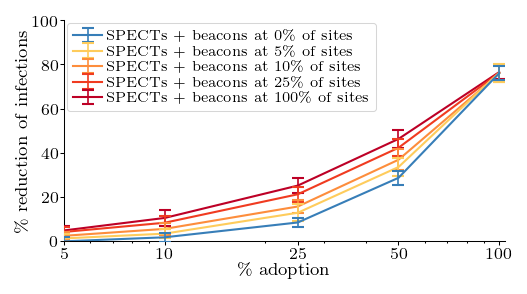

In [42]:
def plot_relative_reduction(*, country, area, mode, ps_adoption, beacon_proportions, beacon_mode='visit_freq', 
                            manual_tracing=True, show_reduction=True, show_spect_with_beacons=False, ylim=None, commithash=None):
    
    if manual_tracing:
        p_recall = 0.1
        p_manual_reachability = 0.5
    else:
        p_recall = 0.0
        p_manual_reachability = 0.0
        
    if mode == 'r_eff':
        if area == 'TU':
            from lib.settings.town_settings_tubingen import town_population
        else:
            raise NotImplementedError('Specify town population')
    else:
        town_population = None
        

        
    if ylim is None:
        if mode == 'r_eff' and show_reduction:
            ylim = (0.0, 50)
        elif mode == 'r_eff' and not show_reduction:
            ylim= (1.0, 3.5)
            
    
    
    plot_filename = (f'comparison-{mode}-{country}-{area}'
                    f'-reduction={show_reduction}'
                    f'-beacon_mode={beacon_mode}'
                    f'-manual_tracing={manual_tracing}'
                    f'-p2p+beacons={show_spect_with_beacons}')
    paths = [
                [f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall={p_recall}'
                 f'-p_manual_reachability={p_manual_reachability}'
                 '.pk' for p_adoption in ps_adoption]
            ]
    titles = ['SPECTs']
    
    for beacon_proportion in beacon_proportions:
        paths.append([f'PanCast/pancast-tracing-{country}-{area}-{commithash}/'
                      f'pancast-tracing-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode={beacon_mode}'
                      f'-p2p_beacon={show_spect_with_beacons}'
                      f'-p_recall={p_recall}'
                      f'-p_manual_reachability={p_manual_reachability}'
                      '.pk' for p_adoption in ps_adoption])
                     
        titles.append(f'PanCast, beacons at {int(beacon_proportion*100)}\% of sites')
    
    
    if show_spect_with_beacons:
        titles = [f'SPECTs + beacons at {int(beacon_proportion*100)}\% of sites' for beacon_proportion in ([0] + beacon_proportions[::-1])]
        new_paths = paths[1:]
        paths = [paths[0]] + new_paths[::-1]
        colors = ['#377eb8', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']
    else:
        colors = None


    baseline_path = (f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}.pk')


    plotter = Plotter()
    plotter.compare_peak_reduction(path_list=paths, 
                                   baseline_path=baseline_path, 
                                   ps_adoption=ps_adoption,
                                   area_population=town_population,
                                   titles=titles,
                                   mode=mode,
                                   show_reduction=show_reduction,
                                   log_xscale=True,
                                   ylim=ylim,
                                   colors=colors,
                                   filename=plot_filename,
                                   figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
                                   figformat='neurips-double',
                                   legend_is_left=True)

              
plot_relative_reduction(
    country='GER', 
    area='TU', 
    mode='cumu_infected',   # Allowed values ['cumu_infected', 'hosp', 'dead', 'r_eff']
    ps_adoption=[1.0, 0.5, 0.25, 0.1, 0.05],
    beacon_proportions=[1.0, 0.25, 0.1, 0.05],#, 0.02],
    beacon_mode='visit_freq',
    manual_tracing=True,
    show_spect_with_beacons=True,
    show_reduction=True,
    commithash=commithash
)

# Quantities over time

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.


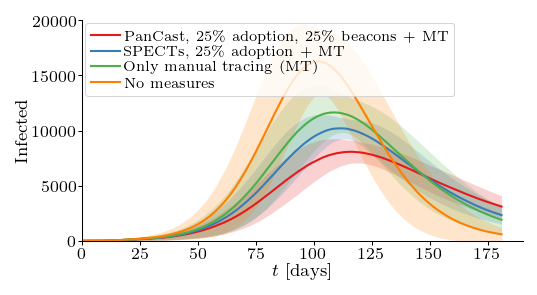

In [5]:
def plot_experiment_over_time(*, country, area, quantity, mode, ymax, 
                              p_adoption=0.25, beacon_proportion=0.05):


    paths = [
#             f'PanCast/pancast-tracing-{country}-{area}-{commithash}/'
#                       f'pancast-tracing-{country}-{area}'
#                       f'-p_adoption={p_adoption}'
#                       f'-beacon_proportion={beacon_proportion}'
#                       f'-beacon_mode=visit_freq'
#                       f'-p2p_beacon=True'
#                       f'-p_recall=0.1'
#                       f'-p_manual_reachability=0.5.pk',
            
            f'PanCast/pancast-tracing-{country}-{area}-{commithash}/'
                      f'pancast-tracing-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode=visit_freq'
                      f'-p2p_beacon=False'
                      f'-p_recall=0.1'
                      f'-p_manual_reachability=0.5.pk',
             
             f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption={p_adoption}'
                 f'-p_recall=0.1'
                 f'-p_manual_reachability=0.5.pk',
             
             f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.1'
                     f'-p_manual_reachability=0.5.pk',
             
             f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.0'
                     f'-p_manual_reachability=0.0.pk',
            ]
    
    labels = [#f'SPECTs + {int(beacon_proportion*100)}\% beacons, {int(p_adoption*100)}\% adoption + MT',
              f'PanCast, {int(p_adoption*100)}\% adoption, {int(beacon_proportion*100)}\% beacons + MT',
              f'SPECTs, {int(p_adoption*100)}\% adoption + MT',
              f'Only manual tracing (MT)',
              f'No measures',
            # f'Baseline with manual tracing',
            # f'Baseline without manual tracing',
             ]
    
#     for path, label in zip(paths, labels):
#         plot_filename = f'{label}-{mode}-{quantity}_over_time-{country}-{area}'
    plot_filename = f'{mode}-{quantity}_over_time-{country}-{area}'
    plotter = Plotter()

    plotter.compare_quantity(
        paths, 
        titles=labels,
        quantity=quantity,
        mode=mode,
        ymax=ymax,
        filename=plot_filename, 
        figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figformat='neurips-double',
        legend_is_left=True)
    
    
    
plot_experiment_over_time(
    country='GER', 
    area='TU',
    quantity='infected',    # Allowed values: ['infected', 'hosp', 'dead']
    mode='total',           # Allowed values: ['total', 'daily', 'cumulative', 'weekly incidence']
    ymax=20000, 
    p_adoption=0.25,
    beacon_proportion=0.25,
)

# Rt over time

Loaded previously extracted data.
Save: plots/daily-nbinom-rts-baseline_with_manual.pdf
Loaded previously extracted data.
Save: plots/daily-nbinom-rts-baseline_without_manual.pdf
Loaded previously extracted data.
Save: plots/daily-nbinom-rts-spect-tracing-p_adoption=0.25.pdf
Loaded previously extracted data.
Save: plots/daily-nbinom-rts-pancast-tracing-p_adoption=0.25-beacons=0.25-spect+beacon=False.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
!!! Error: Input file `plots/prob-secondaryCases-*.pdf' not found!


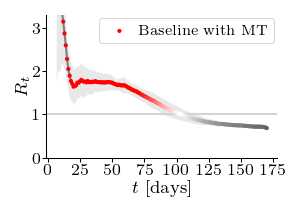

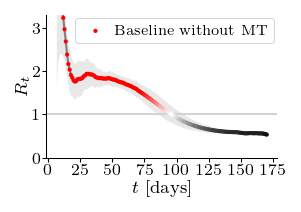

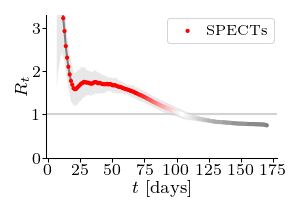

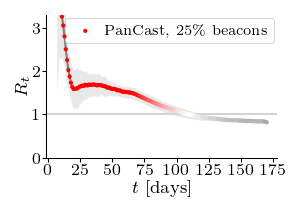

In [43]:
def plot_rt_over_time(*, country, area, ps_adoption, mode='spects', manual_tracing=True, beacon_proportion=None,
                      show_spect_with_beacons=False, plot_rt=True, plot_pmf=False, commithash='c005255'):
        
    if manual_tracing:
        p_recall = 0.1
        p_manual_reachability = 0.5
    else:
        p_recall = 0.0
        p_manual_reachability = 0.0
        
        
    if mode == 'spects':
        plots = {
            f'spect-tracing-p_adoption={p_adoption}' : [
                Plot(label='{:3.0f}\% adoption'.format(100 * p_adoption),
                    path=(f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption={p_adoption}'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}'
                     '.pk'))
            ]
            for p_adoption in ps_adoption
        }
        labels = [f'SPECTs, {int(p_adoption*100)}\% adoption' for p_adoption in ps_adoption]
        labels = [f'SPECTs']
    elif mode == 'baselines':
        plots = {
            f'baseline_with_manual' : [
                Plot(label='manual',
                    path=(f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall=0.1'
                     f'-p_manual_reachability=0.5'
                     '.pk'))],
                
            f'baseline_without_manual' :[
            Plot(label='no_manual',
                path=(f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                 f'spect-tracing-{country}-{area}'
                 f'-p_adoption=0.0'
                 f'-p_recall=0.0'
                 f'-p_manual_reachability=0.0'
                 '.pk'))],
        }
        labels = ['Baseline with MT', 'Baseline without MT']
    elif mode == 'pancast':
        plots = {
            f'pancast-tracing-p_adoption={p_adoption}-beacons={beacon_proportion}-spect+beacon={show_spect_with_beacons}' : [
                Plot(label='{:3.0f}\% adoption'.format(100 * p_adoption),
                    path=(f'PanCast/pancast-tracing-{country}-{area}-{commithash}/'
                      f'pancast-tracing-{country}-{area}'
                      f'-p_adoption={p_adoption}'
                      f'-beacon_proportion={beacon_proportion}'
                      f'-beacon_mode=visit_freq'
                      f'-p2p_beacon={show_spect_with_beacons}'
                      f'-p_recall={p_recall}'
                      f'-p_manual_reachability={p_manual_reachability}'
                      '.pk'))
            ]
            for p_adoption in ps_adoption
        }
        labels = [f'PanCast, {int(p_adoption*100)}\% adoption, {int(beacon_proportion*100)}\% beacons' for p_adoption in ps_adoption]
        labels = [f'PanCast, {int(beacon_proportion*100)}\% beacons']
    
    for i, (plot_filename, plots) in enumerate(plots.items()):

        # extract plot info
        # labels = get_properties(plots, 'label')
        paths = get_properties(plots, 'path')
        path = paths[0]
        
        # plot
        plotter = Plotter()
        plotter.plot_daily_nbinom_rts(
            path=path, 
            filename=plot_filename,
            cmap_range=(0.5, 1.5),
            figsize=lib_plot.FIG_SIZE_NEURIPS_TRIPLE,
            figformat='neurips-double',
            ymax=3.3,
            label=labels[i],
            #xlim=(0, 185),
            x_axis_dates=False,
            subplots_adjust={'bottom':0.2, 'top': 0.98, 'left': 0.12, 'right': 0.96},
        )
          

modes = ['baselines', 'spects', 'pancast']
for mode in modes:
    plot_rt_over_time(
        country='GER', 
        area='TU', 
        ps_adoption=[0.25],#, 0.5, 0.25, 0.1, 0.05, 0.0],
        mode=mode,
        beacon_proportion=0.25,
        show_spect_with_beacons=False,
        commithash=commithash
    )

# Crop pdf margins
!bash crop_pdfs.sh plots/daily-nbinom-rts-*.pdf
!bash crop_pdfs.sh plots/prob-secondaryCases-*.pdf

# Rt over immunity

Loaded previously extracted data.
Loaded previously extracted data.
Loaded previously extracted data.


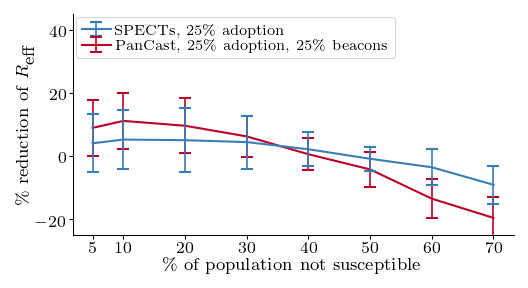

In [153]:
def plot_rt_reduction_over_immunity(*, country, area, p_population=None, p_adoption=0.25, beacon_proportions=None, 
                      manual_tracing=True, show_reduction=True, show_spect_with_beacons=False, commithash=None):
    
    if beacon_proportions is None:
        beacon_proportions = [1.0, 0.25, 0.1]
    
    if manual_tracing:
        p_recall = 0.1
        p_manual_reachability = 0.5
    else:
        p_recall = 0.0
        p_manual_reachability = 0.0
        
    
    if area == 'TU':
        from lib.settings.town_settings_tubingen import town_population
    else:
        raise NotImplementedError('Specify town population')

    
    
    plot_filename = (f'rt-reduction-{country}-{area}'
                    f'-manual_tracing={manual_tracing}')
    
    baseline_path = (f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
                     f'spect-tracing-{country}-{area}'
                     f'-p_adoption=0.0'
                     f'-p_recall={p_recall}'
                     f'-p_manual_reachability={p_manual_reachability}.pk')
    
    
    
    paths = [f'PanCast/spect-tracing-{country}-{area}-{commithash}/'
             f'spect-tracing-{country}-{area}'
             f'-p_adoption={p_adoption}'
             f'-p_recall={p_recall}'
             f'-p_manual_reachability={p_manual_reachability}.pk']
    
    titles = [f'SPECTs, {int(p_adoption*100)}\% adoption']
        
    for beacon_proportion in beacon_proportions:
        paths.append(f'PanCast/pancast-tracing-{country}-{area}-{commithash}/'
                          f'pancast-tracing-{country}-{area}'
                          f'-p_adoption={p_adoption}'
                          f'-beacon_proportion={beacon_proportion}'
                          f'-beacon_mode=visit_freq'
                          f'-p2p_beacon={show_spect_with_beacons}'
                          f'-p_recall={p_recall}'
                          f'-p_manual_reachability={p_manual_reachability}.pk')

        titles.append(f'PanCast, {int(p_adoption*100)}\% adoption, {int(beacon_proportion*100)}\% beacons')

    plotter = Plotter()
    plotter.plot_rt_over_population_infected(paths, 
                                             baseline_path=baseline_path, 
                                             titles=titles,
                                             area_population=town_population, 
                                             show_reduction=show_reduction,
                                             ylim=[-25.0, 45.0],
                                             log_xscale=False,
                                             filename=plot_filename,
                                             figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
                                             figformat='neurips-double',
                                             legend_is_left=True)

              
plot_rt_reduction_over_immunity(
    country='GER', 
    area='TU', 
    p_adoption=0.25,
    beacon_proportions = [0.25],#[1.0, 0.25, 0.1],
    manual_tracing=True,
    show_reduction=True,
    show_spect_with_beacons=False,
    commithash=commithash
)


## ROC

None
Loaded previously extracted data.
index 1 : 0.0 - 0.2
index 2 : 0.2 - 0.4
index 3 : 0.4 - 0.6000000000000001
index 4 : 0.6000000000000001 - 0.8
index 5 : 0.8 - 1.0
Maximum relative % PanCast/SPECT (excluding boundary) tpr 104.07377843662692 bin:  2
Maximum relative % PanCast/SPECT (excluding boundary) prec 101.45025088739973 bin:  2
None
Loaded previously extracted data.
index 1 : 0.0 - 0.2
index 2 : 0.2 - 0.4
index 3 : 0.4 - 0.6000000000000001
index 4 : 0.6000000000000001 - 0.8
index 5 : 0.8 - 1.0
Maximum relative % PanCast/SPECT (excluding boundary) tpr 133.30278592375367 bin:  2
Maximum relative % PanCast/SPECT (excluding boundary) prec 131.61910944060037 bin:  2
[0.5, 0.25, 0.1, 0.05]
Loaded previously extracted data.
index 1 : 0.0 - 0.2
index 2 : 0.2 - 0.4
index 3 : 0.4 - 0.6000000000000001
index 4 : 0.6000000000000001 - 0.8
index 5 : 0.8 - 1.0
Could not compute Maximum relative % PanCast/SPECT (excluding boundary)
Could not compute Maximum relative % PanCast/SPECT (excluding

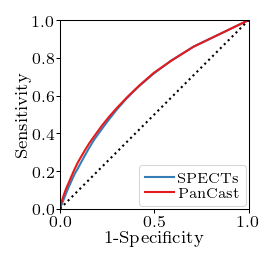

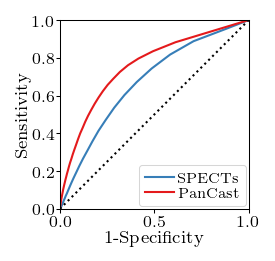

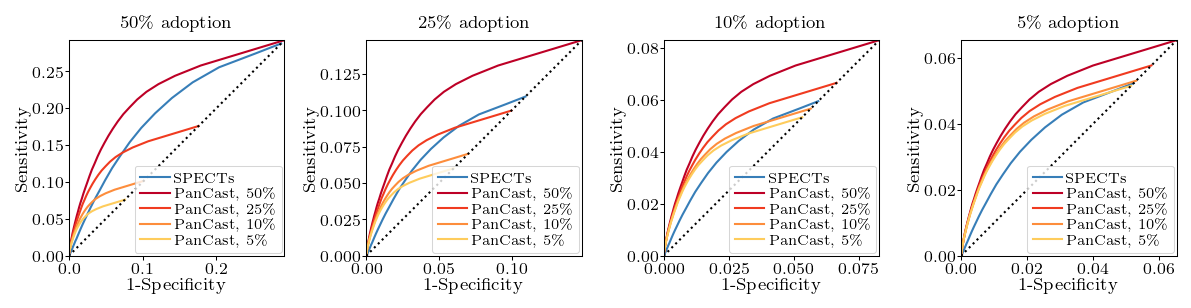

In [282]:
def plot_roc(*, country, area, p_adoption, p_beacon, beta_dispersions, manual_tracing, multiplot=False, commithash=None):
    
    for beta_dispersion in beta_dispersions:
        # Format: {`filename for plot` : `list of `Plot` objects`}
        path = (f'PanCast/beacon-environment-{country}-{area}-{commithash}/'
                          f'beacon-environment-{country}-{area}'
                          f'-beacon=all'
                          f'-p_adoption=1.0'
                          f'-beta_dispersion={beta_dispersion}'
                          '.pk')

        if p_adoption is not None:
            if manual_tracing:
                p_manual_reachability = 0.5
                p_recall = 0.1
            else:
                p_manual_reachability = 0.0
                p_recall = 0.0
        else:
            p_manual_reachability = None
            p_recall = None
            p_beacon = None
            p_adoption = [None]

        if multiplot:
            figsize = (8,3)
            ps_adoption = [p_adoption]
        else:
            figsize = (2.0, 1.8)
            ps_adoption = p_adoption
            
        for p_adoption in ps_adoption:
            print(p_adoption)
            plot_filename = f'ROC-{country}-{area}-p_adoption={p_adoption}-p_beacon={p_beacon}-manual-tracing={manual_tracing}-beta-dispersion={beta_dispersion}'
            plotter = Plotter()

            plotter.plot_roc_curve(
                titles=labels,
                summaries=None,
                paths=[path],
                filename=plot_filename, 
                p_adoption=p_adoption,
                p_manual_reachability=p_manual_reachability,
                p_recall=p_recall,
                p_beacon=p_beacon,
                action='isolate',
                figsize=figsize, 
    #             figsize=(1.8, 1.6), 
                figformat='neurips-double',
                verbose=False,
                use_medical_labels=True)

    
plot_roc(
    country='GER', 
    area='TU', 
    p_adoption=None,
    p_beacon=None,
    beta_dispersions=[2.0, 10.0],
    manual_tracing=True,
    multiplot=False,
    commithash='9ee166f'
)

plot_roc(
    country='GER', 
    area='TU', 
    p_adoption=[0.5, 0.25, 0.1, 0.05],
    p_beacon=[0.5, 0.25, 0.1, 0.05],
    beta_dispersions=[10.0],
    manual_tracing=True,
    multiplot=True,
    commithash='9ee166f'
)
    


In [ ]:
# Crop pdf margins
# !bash crop_pdfs.sh plots/beacon-environment-*.pdf


In [222]:
# plots = {
#          f'beacon-environment-GER-TU-beta_dispersion=20.0' : [
#             Plot(label='tracing-stats', 
#                 path=(f'PanCast/beacon-environment-GER-TU-9ee166f/'
#                       f'beacon-environment-GER-TU'
#                       f'-beacon=all'
#                       f'-p_adoption=1.0'
#                       f'-beta_dispersion=20.0'
#                       '.pk')),
#          ]
#     }
    
# for plot_filename, plots in plots.items():
#     # extract plot info
#     labels = get_properties(plots, 'label')
#     paths = get_properties(plots, 'path')
# summary = load_condensed_summary(paths[0])
# summary['tracing_stats']

# Heat maps

In [ ]:
def plot_relative_quantity_heatmap_beacon_mode(*, country, area, mode,
    ps_adoption, beta_dispersion, beacon_proportions, 
    p_recall, interpolate, cmap):
    
    filename = (
        f'relative-{mode}-heatmap-pancast'
    )
    
    baseline_path = (
        f'spect-tracing-{country}-{area}-{commithash}/'
        f'spect-tracing-{country}-{area}'
        f'-p_adoption=0.0'
        f'-beta_dispersion={beta_dispersion}.pk')
    
    # pair of list of tuples (x, y, path)
    paths = (
        # spect
        [(beacon_proportion, p_adoption, 
         (f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-p_recall={p_recall}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode=random'
          f'-beta_dispersion={beta_dispersion}'
          '.pk'))
        for p_adoption in ps_adoption
        for beacon_proportion in beacon_proportions],
        
        # pancast
        [(beacon_proportion, p_adoption, 
         (f'pancast-tracing-{country}-{area}-{commithash}/'
          f'pancast-tracing-{country}-{area}'
          f'-p_adoption={p_adoption}'
          f'-p_recall={p_recall}'
          f'-beacon_proportion={beacon_proportion}'
          f'-beacon_mode=visit_freq'
          f'-beta_dispersion={beta_dispersion}'
          '.pk'))
        for p_adoption in ps_adoption
        for beacon_proportion in beacon_proportions]
    )

    # plots
    plotter = Plotter()
    plotter.relative_quantity_heatmap(
        xlabel=r'\% sites with beacon',
        ylabel=r'\% adoption',
        path_labels=['placed randomly', 'by integr. visit time'],
        paths=paths, 
        mode=mode,
        baseline_path=baseline_path,
        filename=filename, 
#         figsize=lib_plot.FIG_SIZE_FULL_PAGE_DOUBLE_ARXIV_TALL, 
        figsize=(4.0, 2.0), 
        figformat='neurips-double',
        interpolate=interpolate,
        width_ratio=1,
        cmap=cmap,
    )

    
for mode in ["cumu_infected", "hosp"]:
    plot_relative_quantity_heatmap_beacon_mode(
        mode=mode,
        country='GER', 
        area='TU', 
        ps_adoption=[0.1, 0.25, 0.5, 1.0],
        beta_dispersion=1.0,
        beacon_proportions=[1.0, 0.25, 0.1, 0.05, 0.02],
        p_recall=0.1,
        interpolate='linear',
        cmap=plt.cm.RdYlGn,
    )
        

In [ ]:
!bash crop_pdfs.sh plots/relative-*.pdf


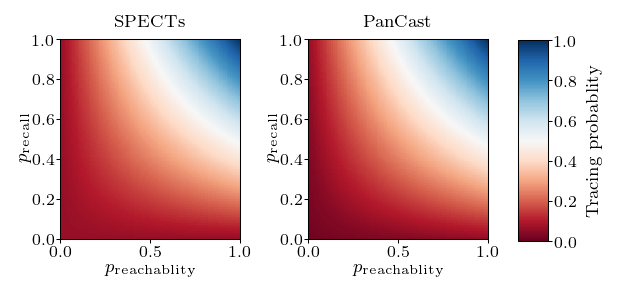

In [480]:
def plot_tracing_probability(mode, p_adoption, p_beacon):
    fig, axs = plt.subplots(1,2, figsize=(4,2))

    p_recall, p_manually_reachable = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

    for k, system in enumerate(['SPECTs', 'PanCast']):
        p_tracable = get_tracing_probability(system, p_adoption=p_adoption, p_manual_reachability=p_manually_reachable, p_recall=p_recall, p_beacon=p_beacon)
        p_tracable_min, p_tracable_max = 0.0, 1.0

        c = axs[k].pcolormesh(p_manually_reachable, p_recall, p_tracable, cmap='RdBu', vmin=p_tracable_min, vmax=p_tracable_max)
        axs[k].set_title(system)
        axs[k].set_ylabel(r'$p_{\rm recall}$')
        axs[k].set_xlabel(r'$p_{\rm reachablity}$')

    fig.tight_layout()
    fig.subplots_adjust(right=0.82)

    cbar_ax = fig.add_axes([0.87, 0.18, 0.05, 0.67])
    cbar = matplotlib.colorbar.ColorbarBase(
        cbar_ax, cmap=plt.cm.RdBu,
        norm=colors.Normalize(vmin=0, vmax=1),
        orientation='vertical')
    cbar.set_label('Tracing probablity', labelpad=5.0)

    plt.show()
    
plot_tracing_probability(mode=None, p_adoption=0.25, p_beacon=0.25)

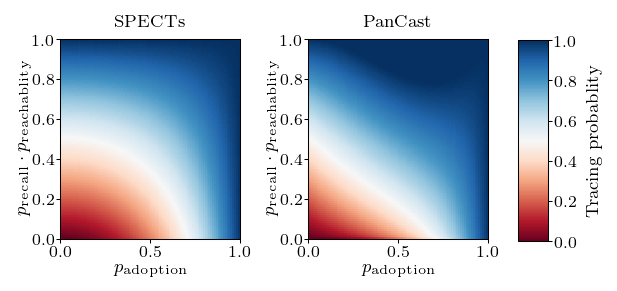

In [483]:
def plot_tracing_probability2(mode, p_beacon):
    fig, axs = plt.subplots(1,2, figsize=(4,2))

    p_recall_reachability, p_adoption = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

    for k, system in enumerate(['SPECTs', 'PanCast']):
        p_recall = np.sqrt(p_recall_reachability)
        p_reachable = np.sqrt(p_recall_reachability)
        p_tracable = get_tracing_probability(system, p_adoption=p_adoption, p_manual_reachability=p_reachable, p_recall=p_recall, p_beacon=p_beacon)

        c = axs[k].pcolormesh(p_adoption, p_recall_reachability, p_tracable, cmap='RdBu', vmin=0.0, vmax=1.0)
        axs[k].set_title(system)
        axs[k].set_ylabel(r'$p_{\rm recall} \cdot p_{\rm reachablity}$')
        axs[k].set_xlabel(r'$p_{\rm adoption}$')

    fig.tight_layout()
    fig.subplots_adjust(right=0.82)

    cbar_ax = fig.add_axes([0.87, 0.18, 0.05, 0.67])
    cbar = matplotlib.colorbar.ColorbarBase(
        cbar_ax, cmap=plt.cm.RdBu,
        norm=colors.Normalize(vmin=0, vmax=1),
        orientation='vertical')
    cbar.set_label('Tracing probablity', labelpad=5.0)

    plt.show()
    
plot_tracing_probability2(mode=None, p_beacon=1.0)

In [470]:
p_tracable = get_tracing_probability('PanCast', 
                                     p_adoption=1, 
                                     p_manual_reachability=0.95,
                                     p_recall=0.95, 
                                     p_beacon=0.95)
print(p_tracable)

0.995125


In [499]:
def get_tracing_probability2(mode, p_adoption, p_manual_reachability, p_recall, p_beacon=0.0):
    if mode == 'SPECTs':
        p_digital = p_adoption ** 2
        p_manual = p_recall * p_manual_reachability * (1 - p_digital)
        p_tracing = p_digital + p_manual
    elif mode == 'PanCast':
        p_digital = (p_adoption ** 2) * p_beacon
        p_manual = p_recall * p_manual_reachability * (1 - p_digital)
        p_digital_manual = p_beacon * p_adoption * p_manual_reachability * (1 - p_digital) * (1 - p_manual)
        p_manual_digital = p_beacon * p_adoption * p_recall * (1 - p_digital) * (1 - p_manual)
        p_tracing = p_digital + p_digital_manual + p_manual_digital + p_manual
        print(p_digital, p_digital_manual, p_manual_digital, p_manual)
    else:
        NotImplementedError('`mode` can only be in ["SPECTs", "PanCast"]')
    return p_tracing


p_tracable = get_tracing_probability2('PanCast', 
                                     p_adoption=0.8, 
                                     p_manual_reachability=0.9,
                                     p_recall=0.95, 
                                     p_beacon=0.8)
print(p_tracable)

0.5120000000000001 0.16380684288000005 0.17290722304000003 0.4172399999999999
1.2659540659200001
